# Transdiagnostic factor derivation, data cleaning, and model-free analyses

### Setup

#### Import Python dependencies and questionnaire data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
import os, joblib, rpy2
from sklearn.metrics import r2_score
from tqdm import tqdm

pal = ["#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80"]
light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]

os.chdir('..')
    # run initially as cd will be the notebook folder otherwise
%load_ext rpy2.ipython
    # warnings about 'quartz' on Windows can be safely ignored.

qns = pd.read_csv('data-raw/gillan_qns.csv').iloc[:,1:] #remove row numbers
scores = pd.read_csv('data-raw/gillan_scores.csv').iloc[:,1:]

c:\users\qderc\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


#### Import pstpipeline R package

In [29]:
%%R
devtools::load_all()

i Loading pstpipeline


## Identifying a subset of questionnaire questions to predict transdiagnostic factors

### Aim and approach

We wish to identify a subset of questions which can acccurately predict factor scores on the three transdiagnostic symptom dimensions identified by [Gillan et al (2016)](https://elifesciences.org/articles/11305), without having to ask all 209 questions. To do this, we train a multi-target lasso regression model on data from their Experiment 2 (n=1400), which can be found on [OSF](https://osf.io/usdgt/), using 5-fold cross validation to optimise the alpha hyperparameter, and find how many questions are needed to predict the factor scores with reasonably high accuracy.

The method and Python code here is adapted from (and broadly identical to) that used by [Wise & Dolan (2020)](https://www.nature.com/articles/s41467-020-17977-w), which was shared on [GitHub](https://github.com/tobywise/online-aversive-learning/blob/master/notebooks/questionnaire_analysis.ipynb). The only difference is that they used a different set of questionnaire data from [Rouault et al. (2018)](https://pubmed.ncbi.nlm.nih.gov/29458997/). While in this study the same 209 questions were asked, it had less fine-grained Likert scoring for the Eating Attitudes Test (scored 0-3 vs 0-5) compared to the original study by [Gillan et al (2016)](https://elifesciences.org/articles/11305). This may have reduced the predictive accuracy of subsets of questions for the "compulsivity" factor.

In [3]:
qns.head()
scores.head()

,id,AD,CIT,SW
0,304SM51WA34XCM4E67SL28LY2UCBS4,3.054589,2.736297,1.644239
1,308Q0PEVB8DPUFML3BKB70KL51T9IW,2.665920,1.506195,1.528145
2,308Q0PEVB8DPUFML3BKB70KL6Q8I9Z,1.629748,1.656867,0.665719
3,308XBLVESI4LB741RISGCYG2G16RBR,1.910352,2.134919,0.352836
4,30BUDKLTXDVUDNIN42H3A5HRS51E5M,3.491979,2.284549,1.204889


### Fit model

#### Hyperparameter optimisation

Loop over candidate alpha values and record $R^2$ and number of items with non-zero coefficients following 5-fold cross-validation.

In [4]:
clf = Lasso()

alpha_values = [
    0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7
]
r2_values = np.empty((3, len(alpha_values)))
n_items = np.empty(len(alpha_values))

# iloc.[:, 1:] used throughout to remove id column
for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha = alpha)
    clf.fit(qns.iloc[:, 1:], scores.iloc[:, 1:]);
    pred = cross_val_predict(clf, qns.iloc[:, 1:], scores.iloc[:, 1:], cv = 5)
    for i in range(3):
        r2_values[i, n] = r2_score(scores.iloc[:, i+1], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis = 1).sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


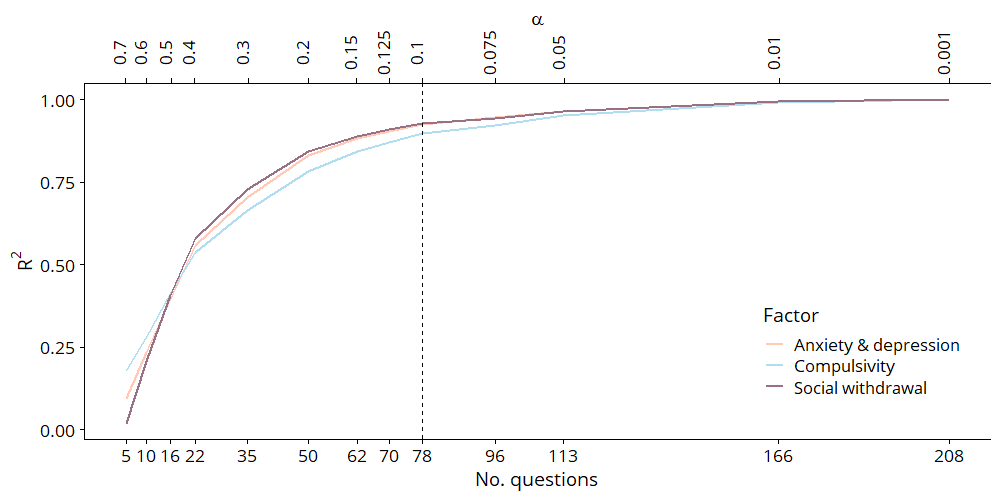

In [5]:
%%R -i r2_values -i light_pal -i alpha_values -i n_items -w 10 -h 5 --units in -r 100

factor_names = c('Anxiety & depression', 'Compulsivity', 'Social withdrawal')
dimnames(r2_values) <- list(factor_names, paste(alpha_values, n_items, sep = "_"))

pstpipeline::plot_factors(
    r2_values, plot_type = "r2_plot", hyp_alph = 0.1, pal = light_pal, 
    font = "Open Sans", font_size = 14
)
# ggplot2::ggsave('notebooks/plots/R2_plot.png', device = "png")

An alpha value of 0.1 looks like it gives a good balance between accurate predictions and a number of questions.

#### Predict factor scores and identify question subset

Using alpha=0.1 and 5-fold CV:

In [6]:
clf = Lasso(alpha=0.1)
pred = cross_val_predict(clf, qns.iloc[:, 1:], scores.iloc[:, 1:], cv=5)

clf.fit(qns.iloc[:, 1:], scores.iloc[:, 1:]);
coefs = clf.coef_.T

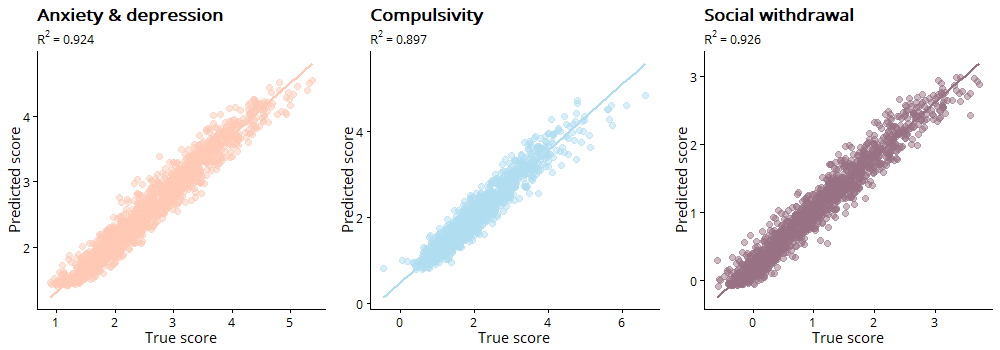

In [7]:
%%R -i scores -i pred -i light_pal -w 10 -h 3.5 --units in -r 100

factors = c("AD", "CIT", "SW")
pstpipeline::plot_factors(
    list("preds" = pred, "scores" = scores), plot_type = "predictive", 
    colnames = factors, titles = factor_names, r2 = r2_values, qn = 78, 
    pal = light_pal, font = "Open Sans"
)
# ggplot2::ggsave('notebooks/plots/alpha01_gillan.png', device = "png")

This indeed seems to do a good job of predicting true factor scores, including for compulsivity. 

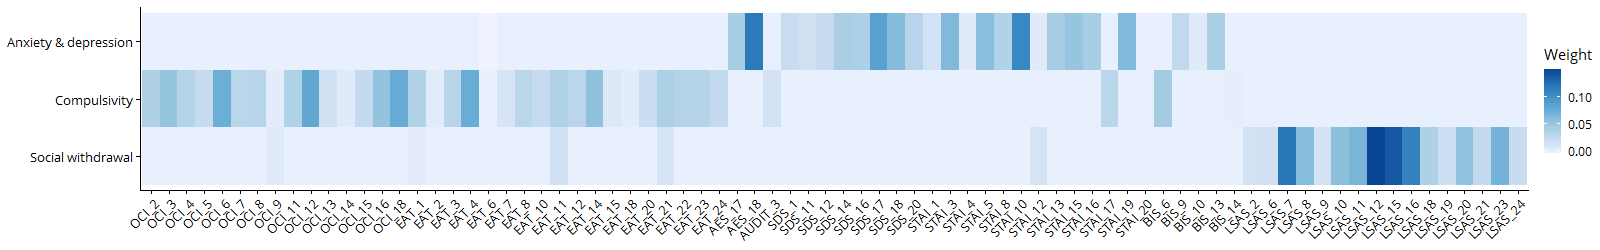

In [8]:
%%R -i coefs -i qns -w 16 -h 2.5 --units in -r 100

pstpipeline::plot_factors(
    list("qns" = qns, "coefs" = coefs), plot_type = "factor_htmp", colnames = factors, 
    titles = factor_names, font = "Open Sans"
)
# ggplot2::ggsave('notebooks/plots/question_subset_heatmap.png', device = "png")

We can see here the 78 included questions (other questions have all three weights = 0). These appear to be fairly specific to the factors; i.e., few questions have weights > 0 for more than 1 factor.

#### Save relevant outputs

In [9]:
# save classifier
joblib.dump(clf, 'outputs/factor_prediction/gillan_classifier_78.pkl')

# save item weights
weight_df = pd.DataFrame(coefs, columns=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], index=np.arange(coefs.shape[0]))
weight_df['item'] = qns.columns[1:]
weight_df.to_csv('outputs/factor_prediction/gillan_classifier_weights_78.csv', index=None)

# save list of questions
reduced_qns = (qns.iloc[:,1:]).iloc[:, np.any(clf.coef_.T != 0, axis = 1)]
reduced_qns.to_csv('outputs/factor_prediction/reduced_qns_gillan_78.csv')

## Data cleaning and factor derivation

### Import and clean raw data

This cell is included for clarity, but this takes a while (and requires the almost 1GB raw .txt file to be downloaded), so we will just load the parsed data from the package.

In [5]:
# %%R
# single <- pstpipeline::import_single(
#     system.file("example_res_single.txt", package = "pstpipeline"), 
#     plot = TRUE, add_sex= TRUE
# )
# multiple <- pstpipeline::import_multiple(
#     system.file("example_res_multiple.txt", package = "pstpipeline"), 
#     separate = FALSE, indiv = TRUE
# )

# all_res_split <- pstpipeline::import_multiple(
#     "data-raw/all_995_complete.txt", add_sex = TRUE
# )
# # this is slow (the .txt file is ~900MB) so not worth doing each time, just here for clarity
# # error about incomplete datasets is more for development, refers to 1 or 2 individuals who didn't finish the task

# save(all_res_split, file = "data/all_res_split.RData")

 ### Calculate factor scores using model fit previously

#### Write and load questionnaire data, and import classifier

In [10]:
%%R
data(pstpipeline::all_res_split)
# readr::write_csv(
#     dplyr::bind_rows(
#      all_res_split$non_distanced$gillan_questions,
#       all_res_split$distanced$gillan_questions
#     ),
#     "outputs/factor_prediction/questionnaire_subset_all_935.csv",
#      progress = FALSE
# );

In [11]:
questionnaire_likert = pd.read_csv(
    'outputs/factor_prediction/questionnaire_subset_all_935.csv'
)
clf = joblib.load('outputs/factor_prediction/gillan_classifier_78.pkl')

#### Predict factor scores in all participants

In [12]:
factor_score_pred = clf.predict(questionnaire_likert.iloc[:, 1:])
factor_score_pred = pd.DataFrame(
    factor_score_pred, columns = ['AD', 'Compul', 'SW']
)
factor_score_pred.loc[:, 'subjID'] = questionnaire_likert['subjID'].values

factor_score_pred.head()
# factor_score_pred.to_csv(
#     'outputs/factor_prediction/all_935_predicted_factor_scores.csv'
# )

,AD,Compul,SW,subjID
0,2.433235,2.530141,2.251934,5b2a2d855b5c0900018b0bf5
1,3.984658,3.717348,1.664801,5ee93e0226f9f0167b877dbe
2,1.960317,1.586168,1.295876,5f5121371ed01f30b8051b73
3,3.512113,2.449905,1.889159,5f22f8d8e7195104928f837f
4,3.471570,3.412705,1.413577,5ef20e5fa9ac1301228a263a


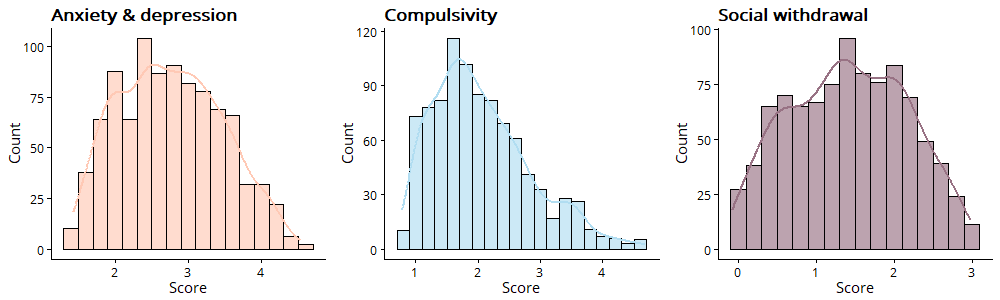

In [13]:
%%R -i factor_score_pred -i light_pal -w 10 -h 3 --units in -r 100

factors = names(factor_score_pred[,1:3])
factor_names = c('Anxiety & depression', 'Compulsivity', 'Social withdrawal')

pstpipeline::plot_factors(
    factor_score_pred, plot_type = "factor_hist", colnames = factors, 
    titles = factor_names, pal = light_pal, font_size = 11, font = "Open Sans"
)

# ggplot2::ggsave('notebooks/plots/all_935_factor_scores.png', device = "png")

#### How do these distributions compare to those originally obtained by [Gillan et al (2016)](https://elifesciences.org/articles/11305)?

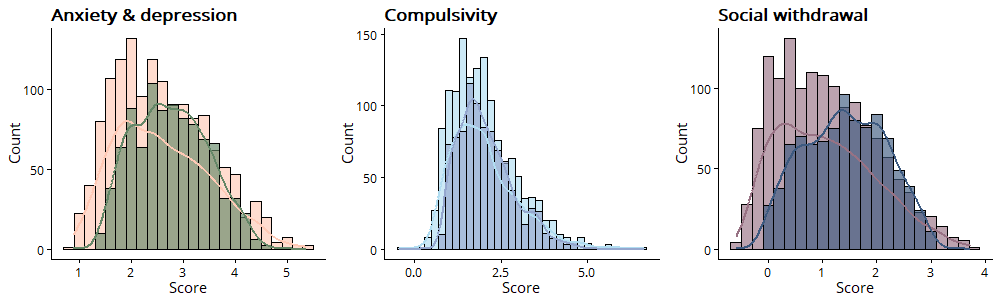

In [14]:
%%R -i factor_score_pred -i pal -w 10 -h 3 --units in -r 100

factor_scores <- factor_score_pred %>%
    dplyr::mutate(dataset = "Our data")
    
all_factor_scores <- read.csv('data-raw/gillan_scores.csv')[-1] %>%
    dplyr::rename(Compul = CIT) %>%
    dplyr::mutate(dataset = "Gillan et al., 2016") %>%
    dplyr::bind_rows(factor_scores)

pstpipeline::plot_factors(
    all_factor_scores, plot_type = "factor_hist", factors, factor_names, 
    pal = pal, group = "dataset", font_size = 11, font = "Open Sans"
)

# ggplot2::ggsave(
#     'notebooks/plots/gillan2016_factor_scores.png', device = "png"
# )

Scores for the "Compulsivity" factor seem relatively close to that seen in the study by [Gillan et al (2016)](https://elifesciences.org/articles/11305), while scores for the "Anxiety/Depression" factor are slightly higher. This may be explained by our aim to actively recruit a sample which included a similar proportion of individuals reporting a psychiatric diagnosis (past or present) to the UK population. Scores for the "Social Withdrawal" were notably higher than those seen in the original dataset. This may be partly confounded by the fact that data collection took place in April-May 2021, when the UK was not yet fully out of lockdown restrictions, as it was predicted primarily from questions on the Liebowitz Social Anxiety Scale (LSAS), which asks participants to rate their fear and avoidance of various social situations (e.g., "Going to a party"). Though participants were asked to try to imagine their feelings towards these situations independently of restrictions, this was likely difficult for many.

### Plot model-free training and test data

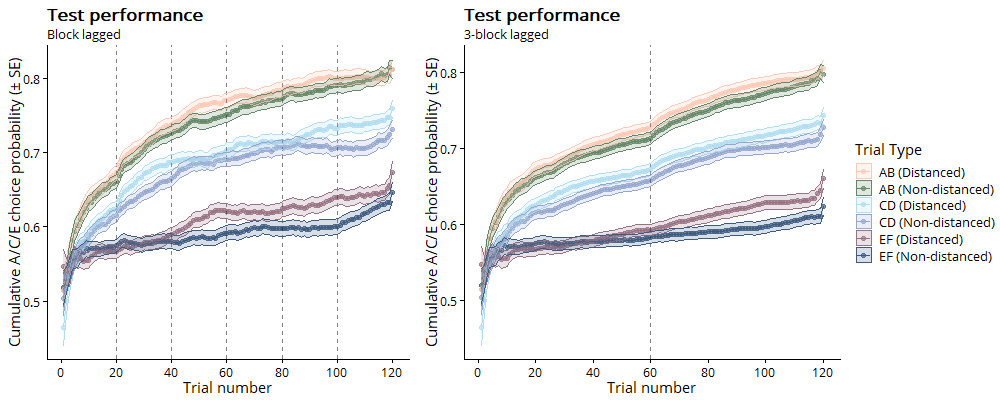

In [28]:
%%R -w 10 -h 4 --units in -r 100
training_plots <- pstpipeline::plot_import(
    all_res_split, types = "train", plt.train = list(c(20, 60)), 
    grp_compare = "distanced", grp_names = c("Non-distanced", "Distanced"), 
    font = "Open Sans", font_size = 11
)

cowplot::plot_grid(
    training_plots[[1]]  + 
        ggplot2::theme(legend.position = "none") + 
        ggplot2::ggtitle("Test performance", subtitle = "Block lagged"), 
    training_plots[[2]] +
        ggplot2::ggtitle("Test performance", subtitle = "3-block lagged"), 
    nrow = 1, rel_widths = c(1,1.4) 
)

# ggplot2::ggsave('notebooks/plots/training_plots_20-60.png', device = "png")

On average the distanced group perform marginally better by the end of the task, particularly in the harder pairs (CD and EF). Does this follow to the test phase?

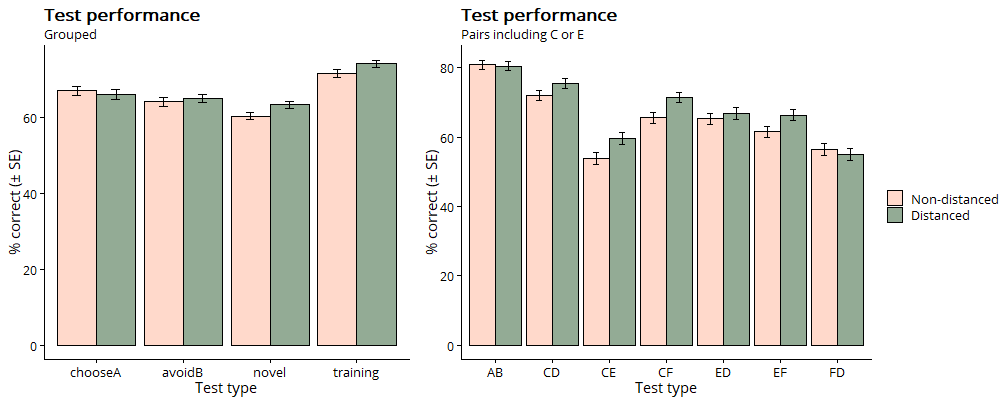

In [30]:
%%R -w 10 -h 4 --units in -r 100

test_plot_grp <- pstpipeline::plot_import(
    all_res_split, types = "test", grp_compare = "distanced", 
    grp_names = c("Non-distanced", "Distanced"), 
    font = "Open Sans", font_size = 11
)
test_plot_ntr <-  pstpipeline::plot_import(
    all_res_split, types = "test", 
    plt.test = list(c("training", "novel"), "individual"), 
    grp_compare = "distanced", grp_names = c("Non-distanced", "Distanced"), 
    font = "Open Sans", font_size = 11)

cowplot::plot_grid(
    test_plot_grp + 
        ggplot2::theme(legend.position = "none") + 
        ggplot2::ggtitle("Test performance", subtitle = "Grouped"),
    test_plot_ntr +
        ggplot2::ggtitle("Test performance", subtitle = "Pairs including C or E"),
    nrow = 1, rel_widths = c(1,1.4)
)

# ggplot2::ggsave('notebooks/plots/test_plots_nov-train.png', device = "png")

Indeed, the distanced group appear to do better in both the training and novel pairs overall. This increase in performance appears driven by the novel and training pairs which include the harder stimuli - "C" or "E".